# PiLoc

* Implementation of `PiLoc: a Self-Calibrating Participatory Indoor Localization System`

## Imports

In [113]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code",
                                         "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from io_f import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass


from py_indoor_loc.plot import plot_floor_map, plot_waypoint_location
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions

In [115]:
from sklearn.cluster import AgglomerativeClustering

In [116]:
from py_indoor_loc.pdr import mm_filter, TurnPointDetector

In [117]:
%matplotlib inline

## Utilities

In [118]:
PARAM_TURN_POINT_THRESHOLD_DEGREES = 30

In [119]:
detect_turn_points = TurnPointDetector(turn_threshold_degrees=PARAM_TURN_POINT_THRESHOLD_DEGREES)

In [120]:
def get_track_filepaths(assignment_df: pd.DataFrame,
                        base_data_dir: str,
                        suffix: str = ".txt") -> list[str]:

  if not base_data_dir.endswith("/"):
    base_data_dir += "/"

  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}{suffix}"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)

  return result

## Env Variables

In [121]:
TRAIN_DATA_DIR = "../../data/train/"
SUPERVISION_PCT = 0.1
WIFI_DATA_DIR = "../../data/wifi_fingerprint_manual/train/"

## Read Train/Test Assignment

In [122]:
# supervision_df = pd.read_csv(
#     "../../data/output/20230903_semi_supervision_setup.csv", index_col=0)
# supervision_df["site_id"] = supervision_df["site_id"].astype("category")
# supervision_df["floor_id"] = supervision_df["floor_id"].astype("category")
# supervision_df["dataset"] = supervision_df["dataset"].astype("category")

# train_test_assignment = pd.read_csv(
#     "../../data/output/20230903_train_test_assignment.csv")
# train_test_assignment["site_id"] = train_test_assignment["site_id"].astype(
#     "category")
# train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype(
#     "category")
# train_test_assignment["dataset"] = train_test_assignment["dataset"].astype(
#     "category")

# supervision_floor_df = supervision_df.loc[
#     (supervision_df["supervision_pct"] == SUPERVISION_PCT) &
#     (supervision_df["dataset"] == "unlabeled")]

# unique_floors = supervision_floor_df[["site_id",
#                                       "floor_id"]].drop_duplicates().values

# print("The number of floors:", unique_floors.shape[0])
# print("The number of tracks:", supervision_floor_df.shape[0])

## PiLoc: Data Collection

* Data collection is the first step of PiLoc.
* Each trajectory is determined by a sequency of steps, i.e. the i-th trajectory $T_i = [s_1, s_2,..., s_n]$, in which $s_i$ is a discrete walking step detected by the linear accelerations from the corresponding phone accelerometer input.
* Each step $s_i$ consists for 4 elements: $s_i = (id_i, x_i, y_i, f_i)$
  * $id_i$ is the global step identifier.
  * $x_i$ and $y_i$ are the relative physical 2D position of the current step with respect to the initial step $s_1$
  * $f_i = (r_1, r_2, ..., r_k)$ represents the WiFi RSS measured at step $i$, where $r_j$ is the received signal strength of $AP_j$ detected.

### Reading Data

In [123]:
# site_id, floor_id = unique_floors[10]

# train_tracks = supervision_floor_df.loc[
#     (supervision_floor_df["site_id"] == site_id) &
#     (supervision_floor_df["floor_id"] == floor_id)]

# test_tracks = train_test_assignment.loc[
#     (train_test_assignment["site_id"] == site_id) &
#     (train_test_assignment["floor_id"] == floor_id) &
#     (train_test_assignment["dataset"] == "test")]

# train_files = get_track_filepaths(train_tracks, base_data_dir=TRAIN_DATA_DIR)
# test_files = get_track_filepaths(test_tracks, base_data_dir=TRAIN_DATA_DIR)
# wifi_train_files = get_track_filepaths(train_tracks,
#                                        base_data_dir=WIFI_DATA_DIR,
#                                        suffix="_wifi_fingerprint.csv")

# wifi_train_files = get_track_filepaths(train_tracks,
#                                        base_data_dir=WIFI_DATA_DIR,
#                                        suffix="_wifi_fingerprint.csv")


* Read data files for a specific sites

In [124]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [125]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

* Read floor map data

In [126]:
floor_info, floor_map = read_floor_data(
  f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


In [253]:
read_data = read_data_file(data_files[10])

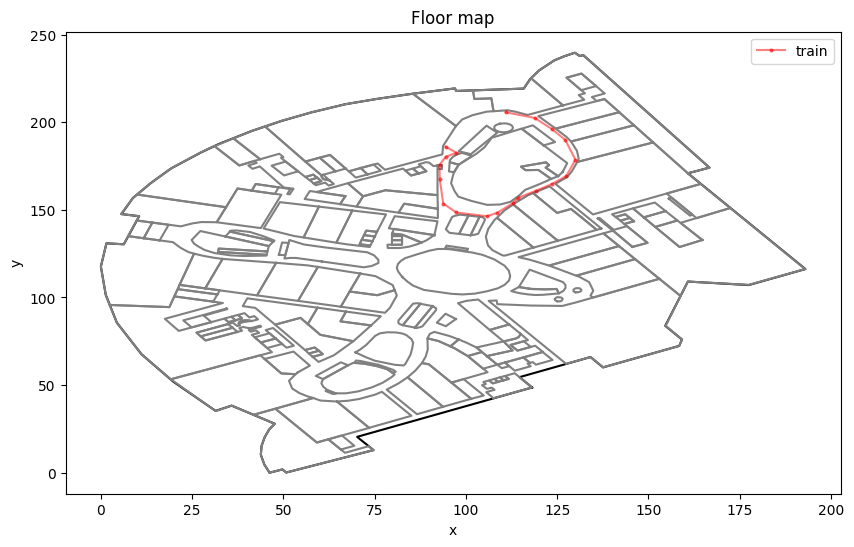

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(read_data.waypoint[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Step Detection

In [129]:
def compute_random_stride_length(size: int,
                                 stride_length_range: tuple[float,
                                                            float] = (0.5, 1.2),
                                 noise_pct: float = 0.15) -> np.ndarray:
  assert noise_pct >= 0 and noise_pct <= 1

  sl_low, sl_high = stride_length_range
  noise = np.random.normal(loc=0, scale=noise_pct, size=size)
  stride_length = np.random.uniform(low=sl_low, high=sl_high, size=size)
  return stride_length * (1 + noise)

In [252]:
def create_sensor_df(read_data: ReadData) -> pd.DataFrame:
  magn_df = pd.DataFrame(read_data.magn,
                         columns=["ts", "magn_x", "magn_y", "magn_z"])
  acce_df = pd.DataFrame(read_data.acce,
                         columns=["ts", "acce_x", "acce_y", "acce_z"])
  ahrs_df = pd.DataFrame(read_data.ahrs,
                         columns=["ts", "ahrs_x", "ahrs_y", "ahrs_z"])
  
  sensor_df = pd.merge(acce_df, magn_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df = pd.merge(sensor_df, ahrs_df, on="ts", how="outer")
  sensor_df.ffill(inplace=True)

  sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
  sensor_df.sort_values("ts", ascending=True, inplace=True)
  return sensor_df

In [256]:
sensor_df = create_sensor_df(read_data)
acce, heading = estimate_acceleration_heading(
    acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
    magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
acce_magnitudes = np.linalg.norm(acce, axis=1)

acce_mean = compute_mean(acce_magnitudes, window_size=8)
acce_var = compute_local_acc_variance(acce_magnitudes, window_size=8)
step_mask, swing, stance = compute_step_positions(acce_var,
                                                      swing_threshold=2.0,
                                                      stance_threshold=1.0,
                                                      window_size=8)


In [257]:
sensor_df.head()

,ts,acce_x,acce_y,acce_z,magn_x,magn_y,magn_z,ahrs_x,ahrs_y,ahrs_z
0,1576400623053,-1.451187,-0.158630,17.356277,-24.407959,-12.979126,-27.729797,0.052248,0.032352,-0.842943
1,1576400623073,-0.643738,0.256760,14.001404,-25.794983,-12.979126,-26.390076,0.048412,0.028237,-0.842768
2,1576400623093,-0.209183,0.763123,11.450973,-27.182007,-13.673401,-25.718689,0.046528,0.018589,-0.841210
3,1576400623113,0.160126,0.406403,9.278244,-27.876282,-12.979126,-28.399658,0.047050,0.006155,-0.838374
4,1576400623133,0.206207,0.245972,6.650009,-29.957580,-13.673401,-25.718689,0.045282,-0.005041,-0.836718


In [132]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 1000
ax.plot(acce_magnitudes[:n_samples], alpha=0.5, label="a", color="black")
ax.plot(acce_mean[:n_samples], alpha=0.5, label="a(mean)", color="red")
ax.plot(acce_var[:n_samples], alpha=0.5, label="a(var)", color="green")
ax.plot(swing[:n_samples], alpha=0.5, label="swing", color="blue")
ax.plot(stance[:n_samples], alpha=0.5, label="stance", color="pink")

for i in range(n_samples):
  if step_mask[i]:
    ax.scatter(i, 0, marker="o", color="red")

ax.set_title("Acceleration (m/s2)")
ax.set_xlabel("Samples")
ax.set_ylabel("Acceleration Magnitude")
ax.legend()

plt.show()

KeyboardInterrupt: 

In [ ]:
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[step_mask]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = np.radians(step_headings[:, 1])
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))
rel_positions = compute_rel_positions(stride_lengths, step_headings)
step_locations = correct_positions(rel_positions, read_data.waypoint)

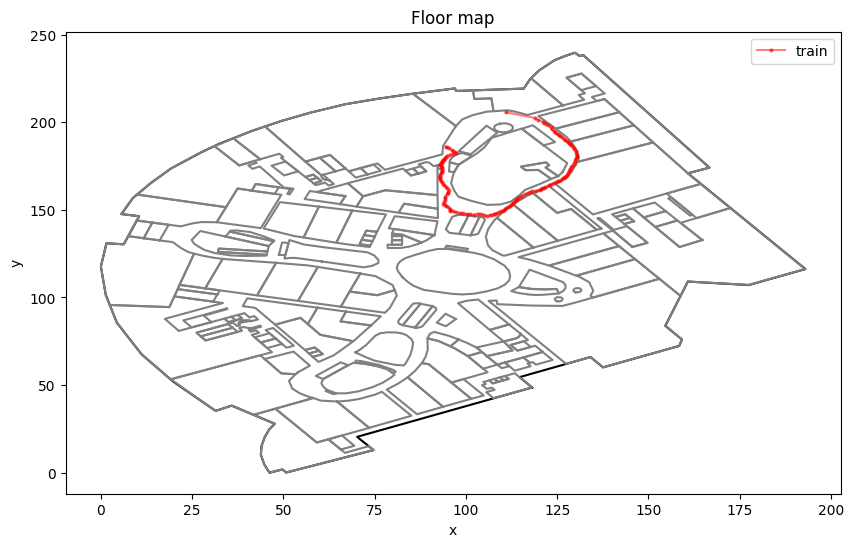

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

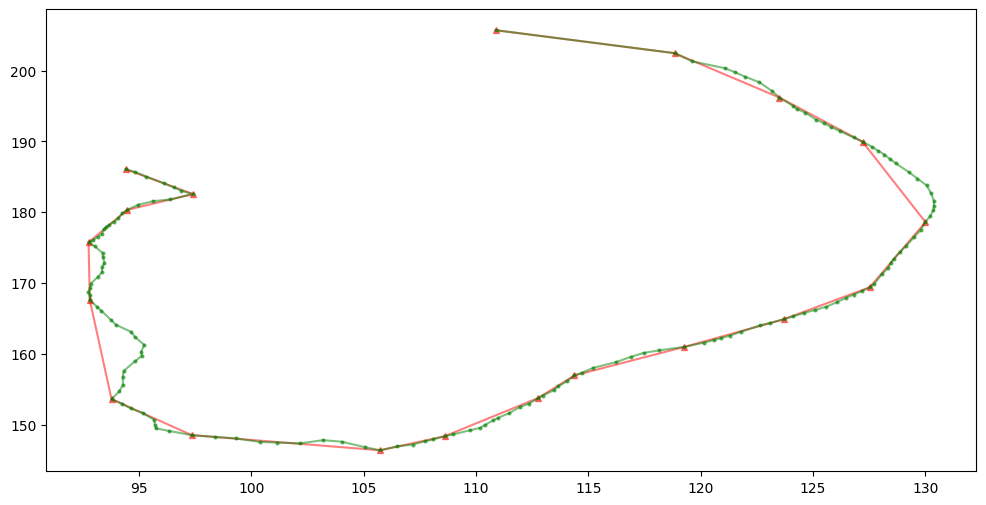

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(read_data.waypoint[:, 1],
        read_data.waypoint[:, 2],
        marker="^",
        markersize=4,
        color="red",
        label="train",
        alpha=0.5)

ax.plot(step_locations[:, 1],
        step_locations[:, 2],
        marker="o",
        markersize=2,
        color="green",
        label="train",
        alpha=0.5)

plt.show()

In [ ]:
def intersect(ra: tuple[int, int], rb: tuple[int, int]):
  min1, max1 = ra
  min2, max2 = rb
  return max(min1, min2), min(max1, max2)

In [ ]:
def union(ra: tuple[int, int], rb: tuple[int, int]):
  min1, max1 = ra
  min2, max2 = rb
  return min(min1, min2), max(max1, max2)

In [ ]:
f_step_headings = mm_filter(step_headings[:, 1])

turn_point_mask = detect_turn_points(f_step_headings)
turn_point_indices = np.where(turn_point_mask)[0]

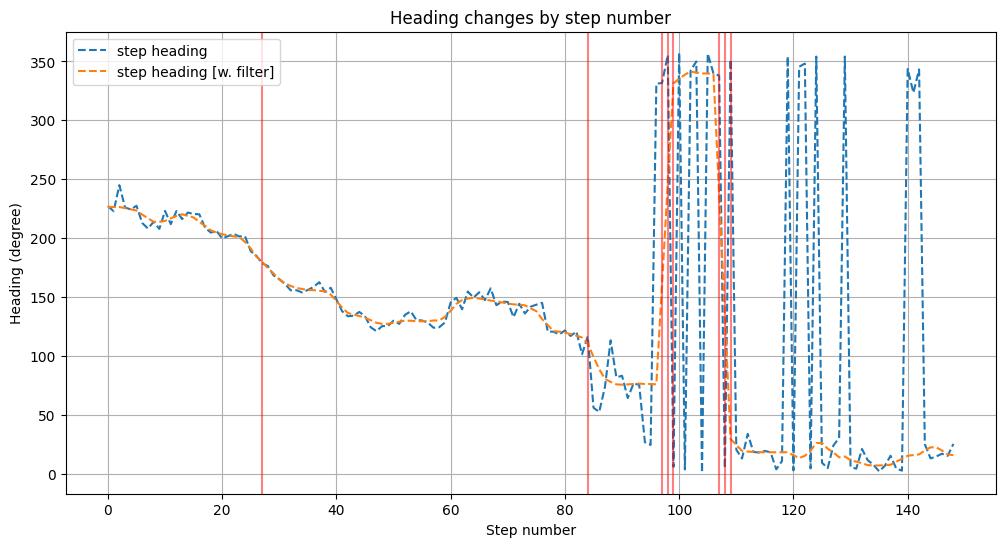

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(np.degrees(step_headings[:, 1]), label="step heading", ls="--")
ax.plot(np.degrees(mm_filter(step_headings[:, 1])),
        label="step heading [w. filter]",
        ls="--")

for turn_index in turn_point_indices:
  ax.axvline(x=turn_index, color="red", alpha=0.5)

ax.set_xlabel("Step number")
ax.set_ylabel("Heading (degree)")
ax.set_title("Heading changes by step number")
ax.grid()
ax.legend()

plt.show()

In [ ]:
if len(turn_point_indices) > 0:
  clustering = AgglomerativeClustering(distance_threshold=2, n_clusters=None).fit(turn_point_indices.reshape(-1, 1))
  turn_point_indices = [0] * len(set(clustering.labels_))

  for cluster_label in clustering.labels_:
    turn_point_indices[cluster_label] = turn_point_indices[clustering.labels_ == cluster_label].mean().astype(np.int32)

else:
  turn_point_indices = []

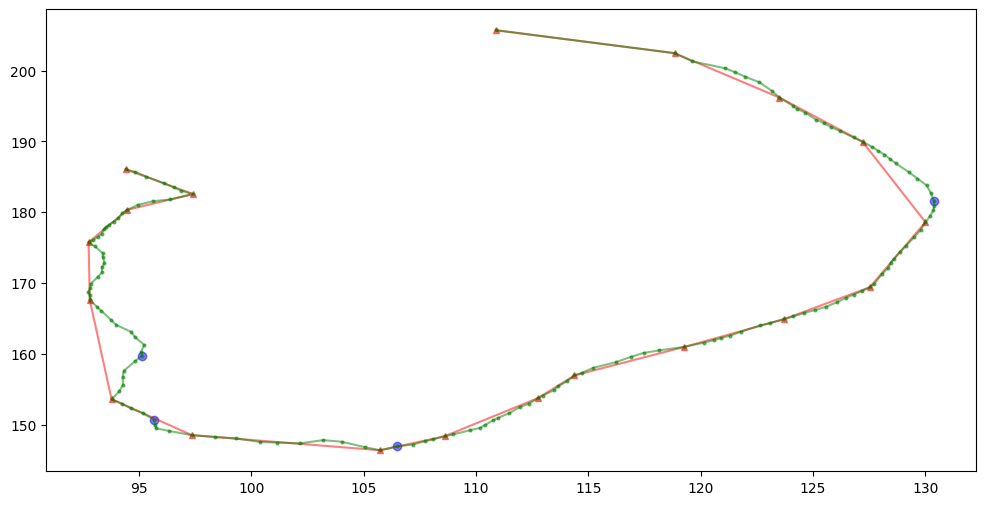

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(read_data.waypoint[:, 1],
        read_data.waypoint[:, 2],
        marker="^",
        markersize=4,
        color="red",
        label="train",
        alpha=0.5)

ax.plot(step_locations[:, 1],
        step_locations[:, 2],
        marker="o",
        markersize=2,
        color="green",
        label="train",
        alpha=0.5)

ax.scatter(step_locations[turn_point_indices, 1],
        step_locations[turn_point_indices, 2],
        marker="o",
        color="blue",
        label="turn",
        alpha=0.5)

plt.show()

In [ ]:
len(turn_point_indices)

4

In [ ]:
turn_point_indices

[108, 84, 98, 27]

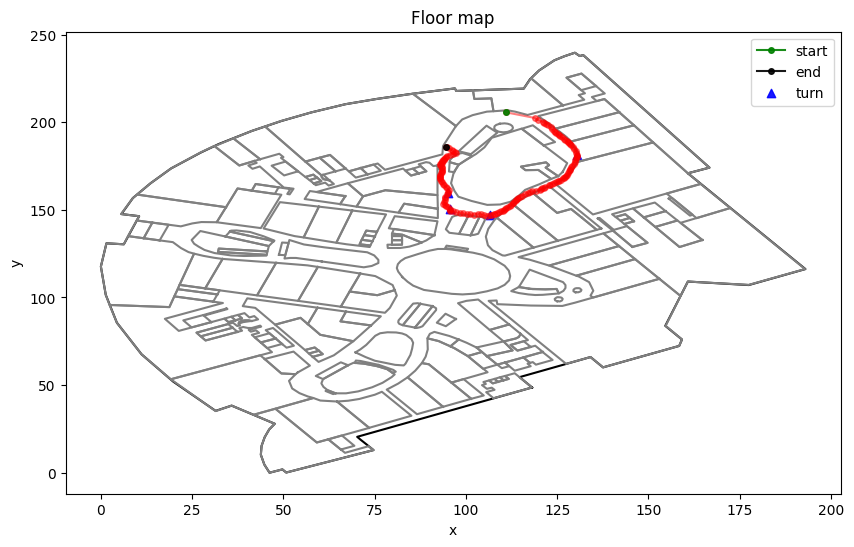

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])

plot_waypoint_location(waypoint_location, ax=ax)

turn_point_indices = np.clip(turn_point_indices, a_min=0, a_max=len(waypoint_location) - 1)
ax.scatter(waypoint_location[turn_point_indices, 0],
        waypoint_location[turn_point_indices, 1],
        marker="^",
        color="blue",
        label="turn",
        alpha=0.9)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

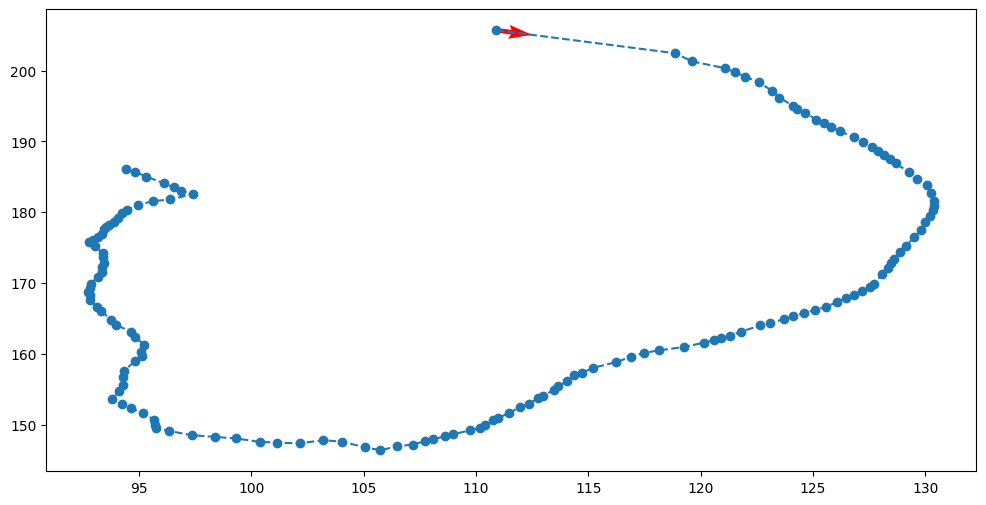

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(step_locations[:, 1], 
        step_locations[:, 2], 
        marker="o", 
        ls="--")

dx = np.diff(step_locations[:, 1])
dy = np.diff(step_locations[:, 2])

ax.quiver(step_locations[:-1, 1], 
          step_locations[:-1, 2], 
          dx, dy, 
          scale_units='xy', 
          angles='xy', 
          scale=5, 
          color='r', 
          width=0.005)

plt.show()

* Segment Extraction

In [ ]:
def split_segments(n_steps: int,
                   turn_indices: np.ndarray,
                   turn_window_n_steps: int = 10,
                   straight_line_min_n_steps: int = 30) -> list:

  turn_mask = np.array([False] * n_steps)
  for turn_index in turn_indices:
    turn_mask[turn_index - turn_window_n_steps:turn_index +
              turn_window_n_steps] = True

  step_flag_straight_line = False
  step_flag_turn = True

  segment_type = {True: "turn", False: "straight_line"}

  segments = []

  step_idx = 0
  step_flag = turn_mask[step_idx]
  step_start_idx, step_stop_idx = step_idx, step_idx

  while step_idx + 1 < n_steps:
    step_idx += 1
    if turn_mask[step_idx] == step_flag:
      step_stop_idx += 1
    else:
      if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
        segments.append(
            (step_start_idx, step_stop_idx, segment_type[step_flag]))

      step_flag = turn_mask[step_idx]
      step_start_idx, step_stop_idx = step_idx, step_idx


  if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
    segments.append((step_start_idx, step_stop_idx, segment_type[step_flag]))

  return segments


In [ ]:
segments = split_segments(len(step_locations),
                          turn_point_indices,
                          turn_window_n_steps=2,
                          straight_line_min_n_steps=10)


In [ ]:
segments

[(0, 24, 'straight_line'),
 (25, 28, 'turn'),
 (29, 81, 'straight_line'),
 (82, 85, 'turn'),
 (96, 99, 'turn'),
 (106, 109, 'turn'),
 (110, 149, 'straight_line')]

## PiLoc: Matching

### Path Correlation

In [342]:
def downsample(arr: np.ndarray,
               downsampling_factor: float = 2,
               kind: str = "linear") -> np.ndarray:
  n_points = np.round(len(arr) / downsampling_factor)
  interp_func = interp1d(np.arange(len(arr)), arr, kind=kind)
  new_indices = np.linspace(0, len(arr), num=n_points)
  return interp_func(new_indices)


In [398]:
def downsample(xs: np.ndarray,
               ys: np.ndarray,
               downsampling_factor: float = 2,
               kind: str = "linear") -> np.ndarray:
  assert len(xs) == len(ys), "x and y are not of the same shape"

  n_points = np.round(len(ys) / downsampling_factor)
  step_size = (xs[-1] - xs[0]) / (n_points - 1)
  interp_func = interp1d(xs, ys, kind=kind)
  new_indices = np.arange(xs[0], xs[-1] + 1e-6, step_size)
  new_indices = np.clip(new_indices, a_min=xs[0], a_max=xs[-1])
  return interp_func(new_indices)


In [399]:
x = np.array([1, 2, 3, 4], dtype=np.int64)
y = np.array([10, 20, 30, 40])

yd = downsample(xs=x, ys=y, downsampling_factor=0.5)
assert len(yd) == 2 * len(y)

In [351]:
def compute_path_correlation(
    s1_x: np.ndarray,
    s1_y: np.ndarray,
    s2_x: np.ndarray,
    s2_y: np.ndarray,
) -> float:
  n1, n2 = len(s1_x), len(s2_x)

  if n1 > n2:
    return compute_path_correlation(s2_x, s2_y, s1_x, s1_y)

  # Perform downsampling to align the longer sequence
  indices = np.arange(n2)
  downsampling_factor = n2 / n1
  d_s2_x = downsample(indices, s2_x, downsampling_factor, "linear")
  d_s2_y = downsample(indices, s2_y, downsampling_factor, "linear")

  n = min(n1, len(d_s2_x))
  corr_x = np.corrcoef(s1_x[:n], d_s2_x[:n])[0, 1]
  corr_y = np.corrcoef(s1_y[:n], d_s2_y[:n])[0, 1]

  return corr_x + corr_y


### Signal Correlation

In [ ]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set, create_fingerprint_vector

In [352]:
def downsample_f(signal_fingerprint: np.ndarray, downsampling_factor: float = 2.0):
  downsampled = []

  xs = np.arange(len(signal_fingerprint))
  for i in range(signal_fingerprint.shape[1]):
    downsampled.append(downsample(xs, signal_fingerprint[:, i], downsampling_factor, kind="nearest"))

  return np.vstack(downsampled).T

In [365]:
def compute_signal_correlation(s1_f: np.ndarray,
                               s2_f: np.ndarray,
                               min_n_apps: int = 10,
                               default_rss: float = -100,
                               rss_sigma: float = 5):
  if len(s1_f) == 0 or len(s2_f) == 0:
    return 0.0

  if len(s1_f) < len(s2_f):
    return compute_signal_correlation(s2_f, s1_f, min_n_apps, default_rss,
                                      rss_sigma)

  if len(s1_f) > len(s2_f):
  # Aligning two RSS fingerprint signal by upsampling
    s2_f = downsample_f(s2_f, downsampling_factor=len(s2_f) / len(s1_f))
    n = min(len(s1_f), len(s2_f))
    s1_f, s2_f = s1_f[:n], s2_f[:n]

  mu1 = s1_f.mean(axis=0)
  mu2 = s2_f.mean(axis=0)
  s1_ap_n_apps = np.count_nonzero(s1_f > default_rss, axis=0)
  s2_ap_n_apps = np.count_nonzero(s2_f > default_rss, axis=0)

  total_ap_n_apps = s1_ap_n_apps + s2_ap_n_apps
  selected_ap = (total_ap_n_apps >= min_n_apps) & (s1_ap_n_apps
                                                   > 0) & (s2_ap_n_apps > 0)
  selected_ap_indices = np.where(selected_ap)[0]

  if len(selected_ap_indices) == 0:
    return 0.0

  corr_signal = 0.0
  for i in selected_ap_indices:
    i_12 = np.abs(mu1[i] - mu2[i]) < rss_sigma
    w = 2.0 / np.abs(mu1[i] + mu2[i])
    if s1_f[:, i].std() == 0 or s2_f[:, i].std() == 0:
      continue
    f_corr = np.corrcoef(s1_f[:, i], s2_f[:, i])[0, 1]
    corr_signal += w * f_corr * i_12

  return corr_signal

## Matching

In [237]:
WIFI_LOCATION_DATA_DIR = "../../data/wifi_location/"

In [238]:
def to_text(v: np.ndarray, sep: str = ","):
  return sep.join([str(vv) for vv in v])


def to_array(v_text: str, sep: str = ",") -> np.ndarray:
  return np.array([float(vv) for vv in v_text.split(sep)], dtype=np.float32)

In [239]:
def create_matrix(wifi_fingerprint_location_df):

  F = np.vstack(wifi_fingerprint_location_df["v"].values.tolist())

  m = np.zeros((F.shape[0], F.shape[1] + 1))
  m[:, 0] = wifi_fingerprint_location_df["sys_ts"].values
  m[:, 1:] = F

  return m

In [ ]:
def read_wifi_fingerprint_location_df(site_id: str, floor_id: str,
                                      track_id: str,
                                      data_dir: str) -> pd.DataFrame:
  if not data_dir.endswith("/"):
    data_dir += "/"

  wifi_fingerprint_location_df = pd.read_csv(
      f"{data_dir}{site_id}/{floor_id}/{track_id}.csv",
      sep="|",
  )
  wifi_fingerprint_location_df["v"] = wifi_fingerprint_location_df["v"].apply(
      lambda vv: to_array(str(vv), sep=","))

  return wifi_fingerprint_location_df

In [ ]:
data_stats = []

for data_file in data_files:
  read_data = read_data_file(data_file)
  track_id = os.path.basename(data_file)[:-len(".txt")]
  wifi_fingerprint_location_df = read_wifi_fingerprint_location_df(
      site_id, floor_id, track_id, data_dir=WIFI_LOCATION_DATA_DIR)
  locations = wifi_fingerprint_location_df[["x", "y"]].values
  distance = np.linalg.norm(locations[1:] - locations[:-1], axis=1).sum()
  n_wifi_points = wifi_fingerprint_location_df.shape[0]
  duration = (wifi_fingerprint_location_df["sys_ts"].values[-1] -
              wifi_fingerprint_location_df["sys_ts"].values[0]) / 1000

  data_stats.append({
      "track_id": track_id,
      "n_wifi_points": n_wifi_points,
      "duration": duration,
      "distance": distance
  })

In [ ]:
data_stats_df = pd.DataFrame(data_stats)

In [ ]:
data_stats_df.head()

,track_id,n_wifi_points,duration,distance
0,5df5ffe560c20f0006ec06f6,15,26.524,26.778057
1,5d04a34edb9d650008324474,36,36.952,45.939757
2,5df5ffc713d568000671a93c,12,23.841,24.941462
3,5df6000213d568000671a952,18,33.212,39.711584
4,5df5ffcd60c20f0006ec06eb,31,67.142,78.118677


In [ ]:
tracks = data_stats_df.loc[(data_stats_df["n_wifi_points"] >= 10) &
                           (data_stats_df["distance"] >= 10) &
                           (data_stats_df["duration"] >= 10), "track_id"].values


In [ ]:
track_set = set(tracks)

In [241]:
def create_displacement_positions(rel_positions: np.ndarray) -> np.ndarray:
  result = np.zeros_like(rel_positions)

  result[:, 0] = rel_positions[:, 0]
  result[:, 1] = np.cumsum(rel_positions[:, 1])
  result[:, 2] = np.cumsum(rel_positions[:, 2])

  return result

In [249]:
from io_f import ReadData
from compute_f import compute_headings
from typing import Iterable

In [264]:
def create_wifi_df(wifi: np.ndarray, max_time_offset_ms: int = 1000) -> pd.DataFrame:
  wifi_df = pd.DataFrame(wifi, columns=["sys_ts", "ssid", "bssid", "rssi", "freq", "last_seen_ts"])

  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.float32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  wifi_df = wifi_df[(wifi_df["sys_ts"] - wifi_df["last_seen_ts"] <= max_time_offset_ms) &
                    (wifi_df["sys_ts"] > wifi_df["last_seen_ts"])]

  return wifi_df

In [265]:
def create_fingerprint_df(wifi_df: pd.DataFrame, 
                          bssid_vector: np.ndarray, 
                          ap_not_seen_rssi: float = -100):
  fingerprint_tuples = []

  for (sys_ts,), group_data in wifi_df.groupby(["sys_ts"]):
    fingerprint_vector = create_fingerprint_vector(
      group_data, bssid_vector, ap_not_seen_rss=ap_not_seen_rssi)
    fingerprint_tuples.append((sys_ts, fingerprint_vector))

  fingerprint_df = pd.DataFrame(fingerprint_tuples, columns=["sys_ts", "v"])
  fingerprint_df.sort_values("sys_ts", inplace=True)
  fingerprint_df.reset_index(drop=True, inplace=True)

  return fingerprint_df

In [261]:
class IdGenerator(object):

  def __init__(self, initial: int = 0) -> None:
    self.initial = initial
    self.current = initial

  def next(self) -> int:
    result = self.current
    self.current += 1
    return result

In [412]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame,
                               track_wifi_df: pd.DataFrame,
                               max_offset_sec: int = 2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts
                                                   <= max_offset_millis)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1]
                                                    <= max_offset_millis)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]

  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[
      left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts -
                                                     prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (
      waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (
      waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(np.vstack([
      wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]
  ]).T,
                                  columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [ ]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False) -> pd.DataFrame:
  """
  Waypoint data extraction and cleaning.
  """

  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [ ]:
def read_bssid_vector(site_id: str, floor_id: str, data_dir: str):
  if not data_dir.endswith("/"):
    data_dir += "/"
  
  with open(f"{data_dir}{site_id}/{floor_id}/bssid.txt", "rt") as f:
    bssid_list = []
    for line in f.readlines():
      if len(line.strip()) > 0:
        bssid_list.append(line.strip())
    return np.array(bssid_list)


In [511]:
@dataclass
class Step(object):
  step_id: int
  timestamp: int
  dx: float
  dy: float
  wifi_f: np.ndarray

  ax: float
  ay: float

In [578]:
@dataclass
class Segment(object):
  segment_id: int
  segment_type: str
  track_id: str
  steps: list[Step]

  def __post_init__(self):
    self.displacements = np.array(
      [[s.timestamp, s.dx, s.dy] for s in self.steps]
    )
    self.wifi_fingerprint = np.array(
      [[s.timestamp, *s.wifi_f.tolist()] for s in self.steps]
    )
    self.exact_positions = np.array(
      [[s.timestamp, s.ax, s.ay] for s in self.steps]
    )

In [579]:
def create_steps(wifi_fingerprint_location_df: pd.DataFrame, id_generator: IdGenerator) -> Iterable[Step]:
  steps = []
  for i, row in wifi_fingerprint_location_df.iterrows():
    step = Step(step_id=id_generator.next(),
                timestamp=row["sys_ts"],
                dx=row["x"],
                dy=row["y"],
                wifi_f=row["v"],
                ax=row["actual_x"],
                ay=row["actual_y"])
    steps.append(step)
  return steps

In [722]:
import bisect

In [740]:
def split_segments(steps: list[Step],
                   turn_point_timestamps: list[int],
                   turn_window_n_steps: int = 2,
                   straight_line_min_n_steps: int = 30,
                   step_lag_duration_ms: int = 2000,) -> list:

  turn_mask = np.array([False] * len(steps))
  for turn_timestamp in turn_point_timestamps:
    turn_index = bisect.bisect_right(steps, x=turn_timestamp, key=lambda t: t.timestamp)
    
    if np.abs(turn_timestamp - steps[turn_index].timestamp) <= step_lag_duration_ms:
      min_index = max(0, turn_index - turn_window_n_steps)
      max_index = min(len(steps), turn_index + turn_window_n_steps + 1)
      turn_mask[min_index:max_index] = True

  step_flag_straight_line = False
  step_flag_turn = True

  segment_type = {True: "turn", False: "straight_line"}

  segments = []

  step_idx = 0
  step_flag = turn_mask[step_idx]
  step_start_idx, step_stop_idx = step_idx, step_idx

  while step_idx + 1 < len(steps):
    step_idx += 1
    if turn_mask[step_idx] == step_flag:
      step_stop_idx += 1
    else:
      if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
        segments.append((step_start_idx, step_stop_idx, segment_type[step_flag]))

      step_flag = turn_mask[step_idx]
      step_start_idx, step_stop_idx = step_idx, step_idx


  if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
    segments.append((step_start_idx, step_stop_idx, segment_type[step_flag]))

  return segments


In [741]:
class SegmentExtractor(object):

  def __init__(self,
               bssid_vector: np.ndarray,
               step_detection_window_size: int = 8,
               step_detection_swing_threshold: float = 2.0,
               step_detection_stance_threshold: float = 1.0,
               stride_length_range: tuple[float, float] = (0.8, 1.2),
               stride_length_noise_pct: float = 0.15,
               wifi_max_time_offset_ms: int = 1000,
               wifi_ap_not_seen_rssi: float = -100,
               split_turn_window_n_steps: int = 4,
               split_straight_line_n_steps: int = 20,
               mm_filter_median_window_size: int = 9,
               mm_filter_mean_window_size: int = 3) -> None:

    self._bssid_vector = bssid_vector
    self._step_detection_window_size = step_detection_window_size
    self._step_detection_swing_threshold = step_detection_swing_threshold
    self._step_detection_stance_threshold = step_detection_stance_threshold
    self._stride_length_range = stride_length_range
    self._stride_length_noise_pct = stride_length_noise_pct
    self._wifi_max_time_offset_ms = wifi_max_time_offset_ms
    self._wifi_ap_not_seen_rssi = wifi_ap_not_seen_rssi
    self._split_turn_window_n_steps = split_turn_window_n_steps
    self._split_straight_line_n_steps = split_straight_line_n_steps
    self._mm_filter_median_window_size = mm_filter_median_window_size
    self._mm_filter_mean_window_size = mm_filter_mean_window_size

  def execute(
      self, read_data: ReadData, segment_id_generator: IdGenerator,
      step_id_generator: IdGenerator
  ) -> tuple[Iterable[Segment], Iterable[Step]]:
    try:
      return self._execute_impl(read_data, segment_id_generator,
                                step_id_generator)
    except Exception as e:
      print(f"[ERROR] Failed to exact segments, caused by: {type(e)}: {str(e)}")
      return [], []

  def _execute_impl(
      self, read_data: ReadData, segment_id_generator: IdGenerator,
      step_id_generator: IdGenerator
  ) -> tuple[Iterable[Segment], Iterable[Step]]:
    result_segments = []

    sensor_df = create_sensor_df(read_data)

    acce = sensor_df[["acce_x", "acce_y", "acce_z"]].values
    acce_magnitudes = np.linalg.norm(acce, axis=1)
    acce_var = compute_local_acc_variance(
        acce_magnitudes, window_size=self._step_detection_window_size)
    step_mask, _, _ = compute_step_positions(
        acce_var,
        swing_threshold=self._step_detection_swing_threshold,
        stance_threshold=self._step_detection_stance_threshold,
        window_size=self._step_detection_window_size)

    ahrs_data = sensor_df[["ts", "ahrs_x", "ahrs_y", "ahrs_z"]].values
    headings = compute_headings(ahrs_data)
    sensor_timestamps = sensor_df["ts"].values
    step_timestamps = sensor_timestamps[step_mask]
    step_headings = compute_step_heading(step_timestamps, headings)

    # Compute stride length
    stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
    stride_lengths[:, 0] = step_timestamps
    stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))

    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    displacements = create_displacement_positions(rel_positions)
    actual_positions = correct_positions(rel_positions, read_data.waypoint)

    wifi_df = create_wifi_df(read_data.wifi,
                             max_time_offset_ms=self._wifi_max_time_offset_ms)
    fingerprint_df = create_fingerprint_df(
        wifi_df,
        bssid_vector=self._bssid_vector,
        ap_not_seen_rssi=self._wifi_ap_not_seen_rssi)

    displacement_waypoint_df = extract_waypoint_df(displacements)
    wifi_displacement_location_df = interpolate_wifi_waypoints(
        displacement_waypoint_df, fingerprint_df)
    wifi_displacement_fingerprint_location_df = pd.merge(
        fingerprint_df, wifi_displacement_location_df, on="sys_ts")

    actual_waypoint_df = extract_waypoint_df(actual_positions)
    wifi_actual_location_df = interpolate_wifi_waypoints(
        actual_waypoint_df, fingerprint_df).rename(columns={
            "x": "actual_x",
            "y": "actual_y"
        })

    wifi_fingerprint_location_df = pd.merge(
        wifi_displacement_fingerprint_location_df,
        wifi_actual_location_df,
        on="sys_ts")

    track_steps = list(
        create_steps(wifi_fingerprint_location_df,
                     id_generator=step_id_generator))

    # Turn point detection
    turn_point_mask = detect_turn_points(
        mm_filter(step_headings[:, 1], 
                  median_window_size=self._mm_filter_median_window_size,
                  mean_window_size=self._mm_filter_mean_window_size))
    turn_point_indices = np.where(turn_point_mask)[0]
    turn_point_timestamps = step_timestamps[turn_point_indices]

    segments = split_segments(
        track_steps,
        turn_point_timestamps,
        turn_window_n_steps=self._split_turn_window_n_steps,
        straight_line_min_n_steps=self._split_straight_line_n_steps)

    for segment_step_start_idx, segment_step_end_idx, segment_type in segments:
      segment_steps = track_steps[segment_step_start_idx:(segment_step_end_idx + 1)]
      
      if len(segment_steps) > 0:
        segment_id = segment_id_generator.next()
        segment = Segment(segment_id=segment_id,
                          segment_type=segment_type,
                          track_id=track_id,
                          steps=segment_steps)
        result_segments.append(segment)

    return result_segments, track_steps

In [742]:
bssid_vector = read_bssid_vector(site_id, floor_id, WIFI_LOCATION_DATA_DIR)
print(len(bssid_vector))

2560


In [764]:
site_segment_extractor = SegmentExtractor(bssid_vector=bssid_vector,
                                          split_turn_window_n_steps=2)
segment_id_generator = IdGenerator(initial=0)
step_id_generator = IdGenerator(initial=0)

site_segments = []
track_steps = []

for data_file in tqdm(data_files):
  read_data = read_data_file(data_file)
  segments, steps = site_segment_extractor.execute(read_data, segment_id_generator, step_id_generator)
  site_segments.extend(segments)
  track_steps.append(steps)
turn_segments = []
straight_line_segments = []

for segment in site_segments:
  if segment.segment_type == "turn":
    turn_segments.append(segment)
  else:
    straight_line_segments.append(segment)

print("n_turn_segments =", len(turn_segments))
print("n_straight_line_segments =", len(straight_line_segments))

 14%|█▍        | 19/132 [00:09<00:41,  2.70it/s]

[ERROR] Failed to exact segments, caused by: <class 'AssertionError'>: 


 93%|█████████▎| 123/132 [01:03<00:03,  2.48it/s]

[ERROR] Failed to exact segments, caused by: <class 'AssertionError'>: 


100%|██████████| 132/132 [01:06<00:00,  1.99it/s]

n_turn_segments = 194
n_straight_line_segments = 14


* Cluster into turn segments and straight line segments

In [ ]:
from multiprocessing import Pool

In [744]:
def compute_segment_path_correlation(s1: Segment, s2: Segment) -> float:
  return compute_path_correlation(s1.displacements[:, 1],
                                  s1.displacements[:, 2],
                                  s2.displacements[:, 1],
                                  s2.displacements[:, 2])


In [747]:
compute_segment_path_correlation(turn_segments[0], turn_segments[2])

0.5214712921511396

In [698]:
def compute_segment_signal_correlation(s1: Segment, s2: Segment, signal_correlation_params: dict | None = None) -> float:
  if signal_correlation_params is None:
    signal_correlation_params = dict()

  f_corr = compute_signal_correlation(s1.wifi_fingerprint[:, 1:],
                                    s2.wifi_fingerprint[:, 1:],
                                    **signal_correlation_params)
  r_corr = compute_signal_correlation(s1.wifi_fingerprint[:, 1:],
                                    s2.wifi_fingerprint[::-1, 1:],
                                    **signal_correlation_params)

  return np.max([f_corr, r_corr])

In [749]:
compute_segment_signal_correlation(turn_segments[0], turn_segments[2],
                                   signal_correlation_params={"min_n_apps": 10})

0.0

In [751]:
len(turn_segments[1].steps)

14

In [783]:
compute_signal_correlation(straight_line_segments[3].wifi_fingerprint[:, 1:],
                           straight_line_segments[4].wifi_fingerprint[::-1, 1:],
                           min_n_apps=8)


-0.0013675481926839381

In [585]:
def compute_segment_correlations(s1: Segment, s2: Segment, signal_correlation_params: dict | None = None) -> tuple:
  
  if signal_correlation_params is None:
    signal_correlation_params = dict()

  path_corr = compute_segment_path_correlation(s1, s2)
  signal_corr = compute_segment_signal_correlation(s1, s2, signal_correlation_params)

  return (path_corr, signal_corr)


In [755]:
%%time

compute_segment_correlations(turn_segments[0], turn_segments[1], signal_correlation_params={"min_n_apps": 2,})

CPU times: user 1.85 s, sys: 16 ms, total: 1.86 s
Wall time: 1.85 s


(-0.9722445709035012, 0.0)

In [765]:
turn_segment_lengths = [len(s.steps) for s in turn_segments]

In [766]:
np.min(turn_segment_lengths), np.max(turn_segment_lengths)

(3, 32)

In [767]:
f_turn_segments = []

for s in turn_segments:
  if len(s.steps) >= 8:
    f_turn_segments.append(s)

In [768]:
len(f_turn_segments)

88

In [587]:
def compute_correlation_matrix(straight_line_segments, n_jobs: int = -1):

  if n_jobs == -1:
    n_jobs = os.cpu_count() - 1

  correlation_matrix = dict()
  n = len(straight_line_segments)
  pair_indices = [(i, j) for i in range(n) for j in range(i + 1, n)]
  pairs = [(straight_line_segments[i], straight_line_segments[j], {"min_n_apps": 4,})
           for i in range(n)
           for j in range(i + 1, n)]

  with Pool(processes=n_jobs) as pool:
    results = [pool.apply_async(compute_segment_correlations, p) for p in pairs]
    for i, r in enumerate(results):
      correlation_matrix[pair_indices[i]] = r.get()

  return correlation_matrix

In [770]:
straight_line_corr_matrix = compute_correlation_matrix(f_turn_segments)

In [784]:
straight_line_corr_matrix_1 = compute_correlation_matrix(straight_line_segments)

In [785]:
data = pd.DataFrame([(*k, *v) for k, v in straight_line_corr_matrix_1.items()],
                    columns=["i", "j", "path_corr", "signal_corr"])

data["path_corr_abs"] = data["path_corr"].abs()

In [786]:
data["signal_corr_abs"] = data["signal_corr"].abs()

In [787]:
data[data["signal_corr_abs"] >= 0.1].sort_values("signal_corr_abs", ascending=False).head(20)

,i,j,path_corr,signal_corr,path_corr_abs,signal_corr_abs
81,9,10,-0.073031,0.259115,0.073031,0.259115
20,1,9,0.009380,0.254006,0.009380,0.254006
6,0,7,-1.739448,0.224009,1.739448,0.224009
74,7,12,1.633919,0.218555,1.633919,0.218555
84,9,13,0.023189,0.214678,0.023189,0.214678
11,0,12,-1.970231,0.199513,1.970231,0.199513
1,0,2,1.864567,0.176024,1.864567,0.176024
34,2,12,-1.931186,0.166708,1.931186,0.166708
55,5,6,0.013984,0.115186,0.013984,0.115186
21,1,10,-1.968349,0.101694,1.968349,0.101694


In [314]:
def plot_segment_exact_locations(segments: Iterable[Segment], ax: plt.Axes | None = None) -> plt.Axes:
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

  for segment in segments:
    plot_waypoint_location(segment.exact_positions[:, 1:],
                           ax=ax,
                           plot_kwargs={"label": str(segment.segment_id), "ls": "--"},)
  
  return ax

In [329]:
def plot_segment_displacements(segments: Iterable[Segment], ax: plt.Axes | None = None) -> plt.Axes:
  if ax is None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

  for segment in segments:
    plot_waypoint_location(segment.displacements[:, 1:],
                           ax=ax,
                           plot_kwargs={"label": str(segment.segment_id), "ls": "--"},)
  
  return ax

In [762]:
np.argmax(turn_segment_lengths)

52

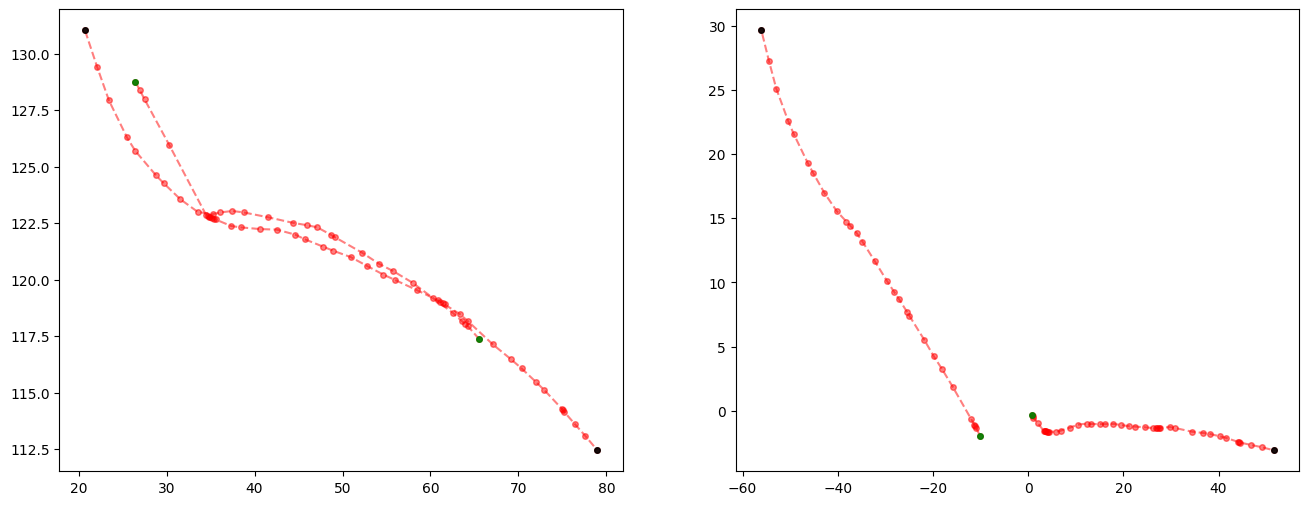

In [788]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

segments = [
  straight_line_segments[0],
  straight_line_segments[7],
]

plot_segment_exact_locations(segments, ax=ax1)
plot_segment_displacements(segments, ax=ax2)

plt.show()